# <center> `Importing libraries`  </center>

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from keras import layers,Input,Model
from keras.utils.vis_utils import plot_model
from tensorflow.keras.losses import binary_crossentropy

import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline
import seaborn as sns
sns.set()

# <center> `Data loading and preprocessing`  </center>

In [3]:

(x_train, y_train_), (x_test, y_test_) = keras.datasets.mnist.load_data()
image_size = x_train.shape[1]

In [4]:

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

In [5]:
input_shape = (image_size, image_size, 1)
latent_dim = 4
batch_size = 100
kernel_size = 3
filters = 16
latent_dim = 2 
epochs = 30
validation_split=0.2

# <center> `Encoder-part of VAE`  </center>

In [6]:
x_in = Input(shape=input_shape)

en_conv1    = layers.Conv2D(filters=filters,kernel_size=kernel_size,activation='relu',padding='same')(x_in)
en_conv2    = layers.Conv2D(filters=filters,kernel_size=kernel_size,activation='relu',padding='same')(en_conv1)
en_pooling  = layers.MaxPooling2D((2, 2))(en_conv2)
en_dropout  = layers.Dropout(0.25)(en_pooling)
conv_shape  = keras.backend.int_shape(en_conv2)

en_flatten  = layers.Flatten()(en_dropout)

en_dense1   = layers.Dense(128, activation="relu",kernel_initializer='he_normal')(en_flatten)

z_mu    = layers.Dense(latent_dim ,name="latent_mu")(en_dense1)
z_sigma = layers.Dense(latent_dim, name="latent_sigma")(en_dense1)

2022-03-06 22:59:50.752076: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-06 22:59:50.757406: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-03-06 22:59:50.757427: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-03-06 22:59:50.758435: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [7]:
#REPARAMETERIZATION
def sample_z(args):
    z_mu, z_sigma = args
    eps = K.random_normal(shape=K.shape(z_mu))
    return z_mu + K.exp(z_sigma / 2) * eps



In [8]:
#sampling
z = layers.Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])


In [9]:
Encoder = Model(x_in, [z_mu, z_sigma, z], name='encoder')
Encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 16)   160         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 16)   2320        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 16)   0           ['conv2d_1[0][0]']               
                                                                                            

# <center> `Decoder-part of VAE`  </center>

In [10]:
de_in=Input(shape=(latent_dim,) , name="decoder_input")

de_dense1  = layers.Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu',kernel_initializer='he_normal')(de_in)

de_reshape = layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(de_dense1)
de_drop    = layers.Dropout(0.25)(de_reshape)
de_deconv1 = layers.Conv2DTranspose(filters=filters,kernel_size=kernel_size,activation='relu',padding='same')(de_drop)
de_deconv2 = layers.Conv2DTranspose(filters=filters,kernel_size=kernel_size,activation='relu',padding='same')(de_deconv1)

de_out = layers.Conv2DTranspose(1, 5,padding='same', activation='relu', name='decoder_output')(de_deconv2)


In [11]:
Decoder = Model(de_in, de_out, name='decoder')
Decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 12544)             37632     
                                                                 
 reshape (Reshape)           (None, 28, 28, 16)        0         
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 16)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 16)       2320      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       2320      
 ranspose)                                                 

# <center> `custom loss(KL+reconstruction loss) and VAE modeling`  </center>

In [12]:
z_decoded = Decoder(z)
input_img=x_in
x=de_out

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 16)   160         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 16)   2320        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 16)   0           ['conv2d_1[0][0]']               
                                                                                            

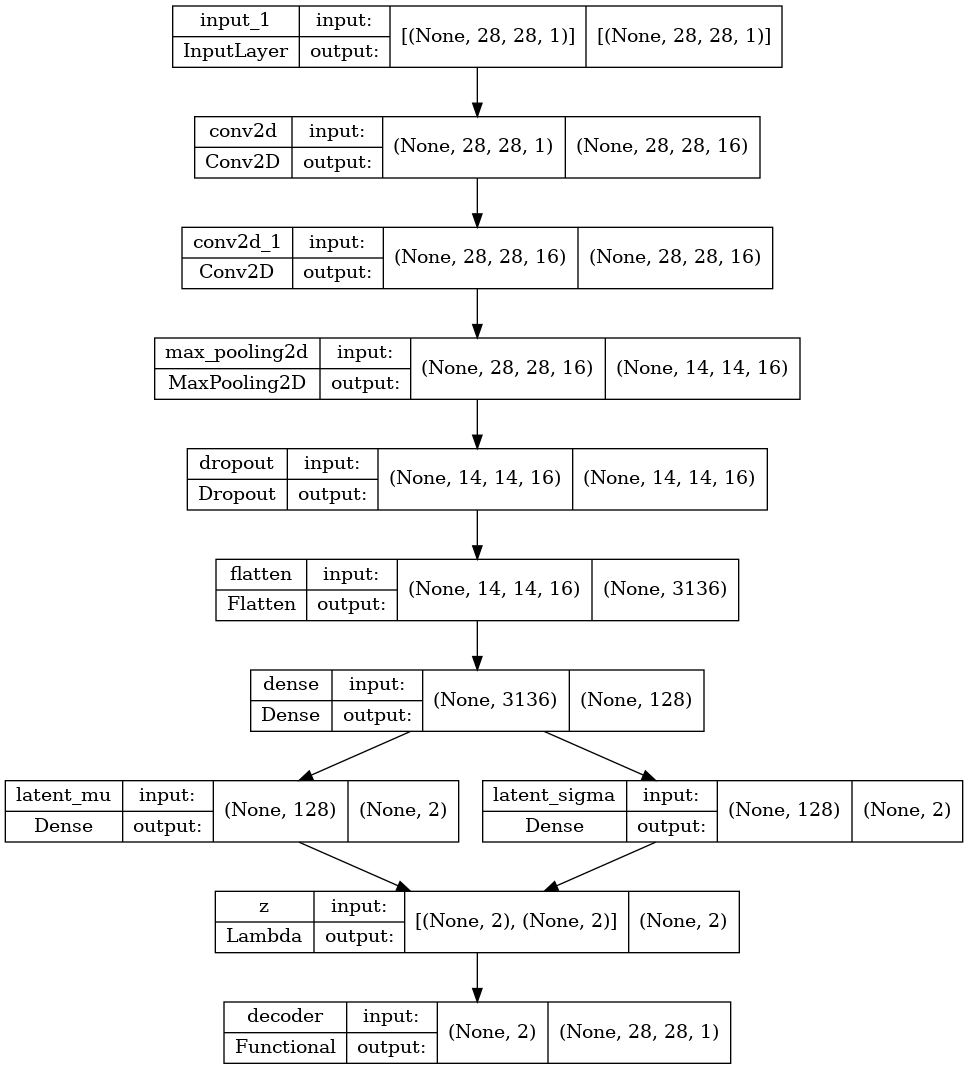

In [28]:
vae = Model(x_in, z_decoded)
vae.summary()

plot_model(vae, to_file='Vae_Mnist_Encoder.png', show_shapes=True, show_layer_names=True)

In [14]:
#reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(x_in, z_decoded)), axis=[1, 2, 3])
#kl_loss = -0.5 * (1 + z_sigma - tf.square(z_mu) - tf.exp(z_sigma))
#kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))


reconstruction_loss = K.sum(K.binary_crossentropy(x_in, z_decoded), axis=[1, 2, 3])
kl_loss = - 0.5 * K.sum(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)


# <center> `VAE compilation and training`  </center>

In [15]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")

vae.compile(optimizer=optimizer)

In [16]:
import os

weights_file = 'vae_cnn_mnist.h5'

if os.path.exists(weights_file):
    vae.load_weights(weights_file)
    print('Loaded weights!')
else:
    vae.fit(x_train, None, epochs = epochs, batch_size = batch_size, validation_split = validation_split)
    vae.save_weights('vae_cnn_mnist.h5')
    


Epoch 1/30
480/480 [==============================] - 70s 144ms/step - loss: 302.0148 - val_loss: 214.2876
Epoch 2/30
480/480 [==============================] - 67s 139ms/step - loss: 217.0788 - val_loss: 203.0850
Epoch 3/30
480/480 [==============================] - 72s 151ms/step - loss: 256.5345 - val_loss: 214.8030
Epoch 4/30
480/480 [==============================] - 65s 136ms/step - loss: 206.2030 - val_loss: 216.7543
Epoch 5/30
480/480 [==============================] - 65s 135ms/step - loss: 199.8596 - val_loss: 191.3867
Epoch 6/30
480/480 [==============================] - 66s 138ms/step - loss: 193.5902 - val_loss: 194.1361
Epoch 7/30
480/480 [==============================] - 66s 138ms/step - loss: 190.8382 - val_loss: 185.2634
Epoch 8/30
480/480 [==============================] - 66s 138ms/step - loss: 187.8887 - val_loss: 182.3728
Epoch 9/30
480/480 [==============================] - 66s 138ms/step - loss: 186.6467 - val_loss: 181.1314
Epoch 10/30
480/480 [================

In [17]:
x_test_predicted=vae.predict(x_test)


In [18]:
x_test.shape

(10000, 28, 28, 1)

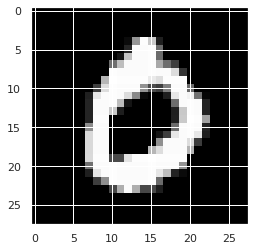

In [26]:
plt.imshow(x_test[3], cmap='gray',)

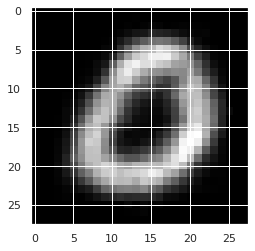

In [25]:
plt.imshow(x_test_predicted[3], cmap='gray',)

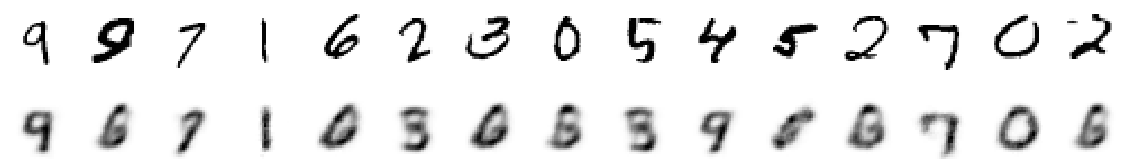

In [27]:

fig, axes = plt.subplots(2, 15, figsize=(20, 3))

def show(im):
    sns.heatmap(im.reshape((28, 28)), cmap='Greys', cbar=False, square=True, )

sample = np.random.randint(len(x_test), size=15)

for i in range(15):
    axes[0, i].get_xaxis().set_visible(False)
    axes[0, i].get_yaxis().set_visible(False)
    plt.sca(axes[0, i])
    show(x_test[sample[i]])
    axes[1, i].get_xaxis().set_visible(False)
    axes[1, i].get_yaxis().set_visible(False)
    plt.sca(axes[1, i])
    show(x_test_predicted[sample[i]])

plt.show()

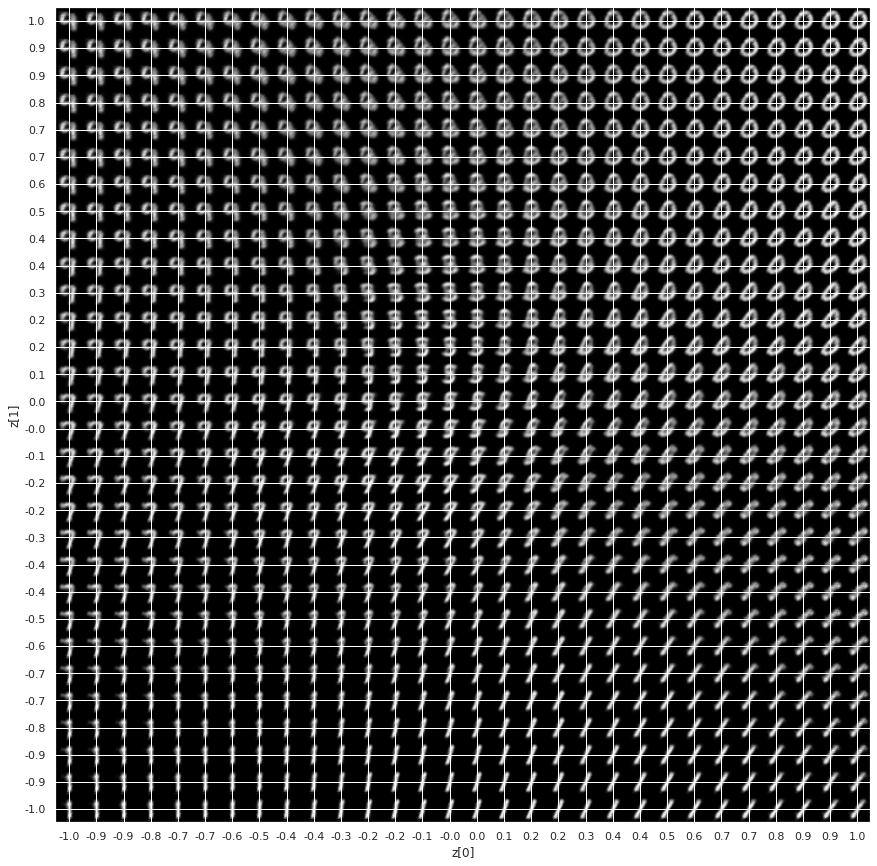

In [29]:
def plot_latent_space(Decoder, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent spaceaa
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = Decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(Decoder)